#### **This notebook contains the functions used to clean the spectra.**

Import Libraries

In [10]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns
from Spectra_Preparation_Functions import *
import matplotlib.pyplot as plt

Read the spectral data

In [11]:
# df = pd.read_csv("../../data/exosomes.raw_spectrum_400-1800.csv")
df = pd.read_csv("../../data/400-1800_with_raw_scaled_surface_pagerank.csv")

In [12]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,0.610024
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,0.610024
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,0.610024
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,0.610024
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,0.610024
...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,1.201164
6239201,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,1.201164
6239202,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,1.201164
6239203,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,1.201164


#### **Select the chosen cleaning parameters then run the functions**

Choose the Parameters

In [13]:
# # Best Full Spectrum Parameters

# Optuna Outlier Removed Parameters
pagerank_cutoff = 0.902461
despike_ma = 57
despike_threshold = 3.75
lam = 10 ** 11
p = 0.074
window_size = 51
poly_order = 3

# pagerank_cutoff = 0.902461
# despike_ma = 57
# despike_threshold = 3.75
# lam = 10 ** 8
# p = 0.056
# lam_1 = 10**-4
# window_size = 19
# poly_order = 2

#### **Here is an example on 1 Spectra**

<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

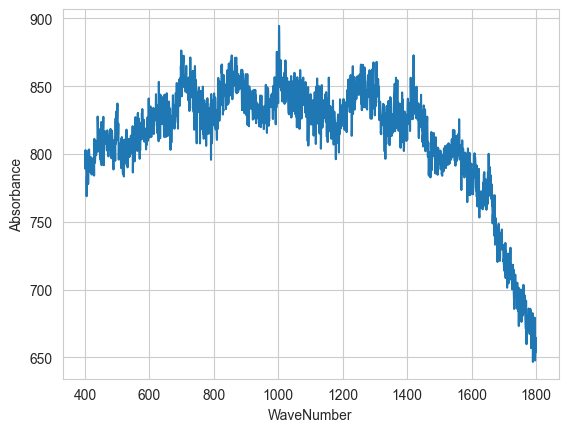

In [14]:
sample = df[df['SpecID'] == "201210-2-08"]
sns.set_style('whitegrid')
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

Despike

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22828\250951349.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))


<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

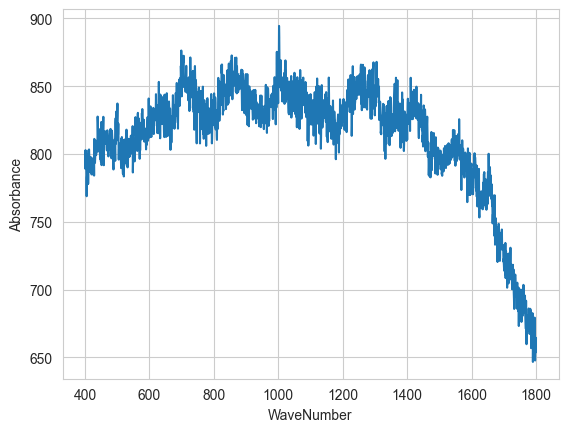

In [15]:
sample['Absorbance'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

Baseline Correction

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22828\2601916869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))


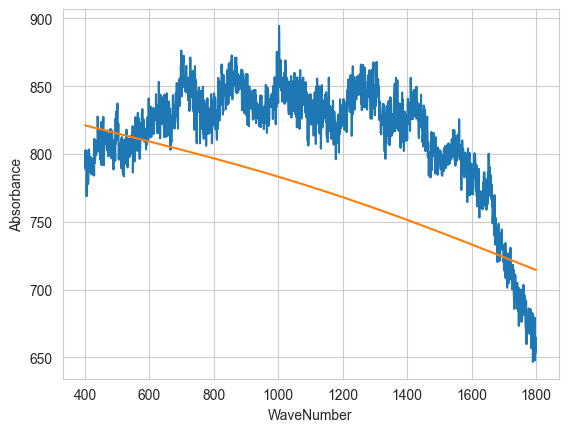

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22828\2601916869.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']


<AxesSubplot: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

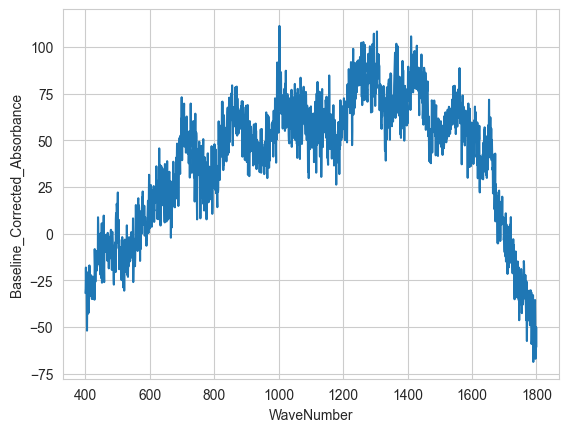

In [16]:
sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
#sample['Baseline'] = sample.groupby('SpecID')['Absorbance'].transform(lambda x: iasls_baseline_correction(x, lam=lam, p=p, lam_1=lam_1))

sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.lineplot(x="WaveNumber", y="Baseline", data=sample)
plt.show()

# Subtract the baseline
sample['Baseline_Corrected_Absorbance'] = sample['Absorbance'] - sample['Baseline']
sns.lineplot(x="WaveNumber", y="Baseline_Corrected_Absorbance", data=sample)

Smoothing Baseline_Corrected_Spectrum

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22828\1425479424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))


<AxesSubplot: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

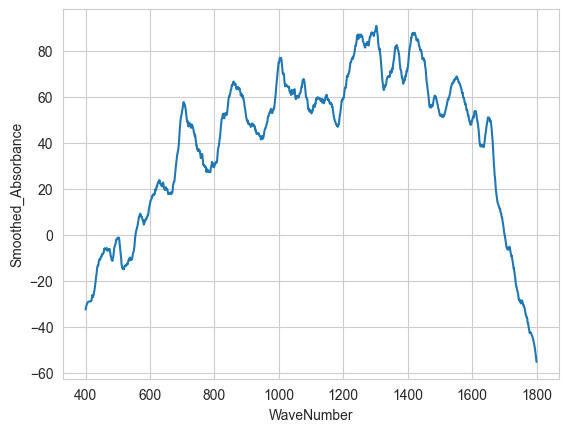

In [17]:
# Apply Savitzky-Golay filter to smooth the Absorbance values
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

Scale the spectra

C:\Users\FX 8320\AppData\Local\Temp\ipykernel_22828\1189992890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: vector_normalise(x))


<AxesSubplot: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

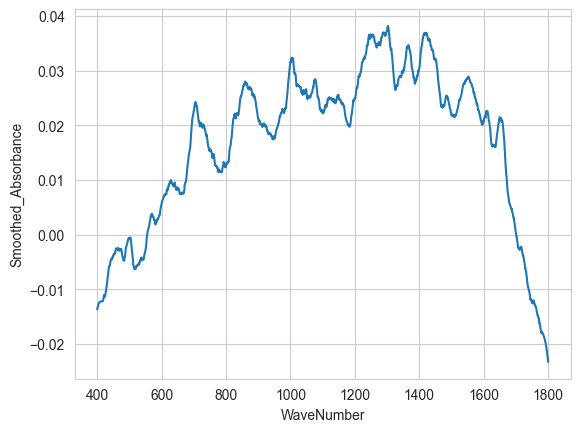

In [18]:
sample['Smoothed_Absorbance'] = sample.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: vector_normalise(x))
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)

In [19]:
df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x, ma=despike_ma, threshold=despike_threshold))

In [20]:
df['Baseline'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: asls_baseline_correction(x, lam=lam, p=p))
#df['Baseline'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: iasls_baseline_correction(x, lam=lam, p=p, lam_1=lam_1))

In [21]:
df['Absorbance'] = df['Absorbance'] - df['Baseline']

In [22]:
# df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [23]:
# df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))
df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: vector_normalise(x))
# df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: svn_normalise(x))

In [24]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank,Baseline
0,201210-1-00,293,400.22778,-0.001247,201210-1,Normal,0.610024,1769.569028
1,201210-1-00,294,400.91116,0.001740,201210-1,Normal,0.610024,1769.330009
2,201210-1-00,295,401.59454,-0.000019,201210-1,Normal,0.610024,1769.090991
3,201210-1-00,296,402.27789,-0.003967,201210-1,Normal,0.610024,1768.851972
4,201210-1-00,297,402.96127,-0.003110,201210-1,Normal,0.610024,1768.612953
...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,-0.016926,210526-3,Hyperglycemia,1.201164,1753.639314
6239201,210526-3-09,2338,1797.72200,-0.014938,210526-3,Hyperglycemia,1.201164,1753.341720
6239202,210526-3-09,2339,1798.40550,-0.014875,210526-3,Hyperglycemia,1.201164,1753.044127
6239203,210526-3-09,2340,1799.08890,-0.013774,210526-3,Hyperglycemia,1.201164,1752.746533


**Most Important Features Only**

In [25]:
# features = pd.read_csv("../../data/et_greedy_search_10.csv", index_col=0)
# display(features)
# df = df[df['WaveNumber'].isin(features['Selected Features'])]
# display(df)

,Selected Features
0,512.98407
1,521.18451
2,585.42139
3,691.34393
4,702.27789
5,743.28021
6,830.75171
7,872.43738
8,886.10480
9,917.53986


,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank,Baseline
165,201210-1-00,458,512.98407,-0.012063,201210-1,Normal,0.610024,1730.128691
177,201210-1-00,470,521.18451,-0.005865,201210-1,Normal,0.610024,1727.259734
271,201210-1-00,564,585.42139,0.004388,201210-1,Normal,0.610024,1704.776477
426,201210-1-00,719,691.34393,0.042156,201210-1,Normal,0.610024,1667.613606
442,201210-1-00,735,702.27789,0.044079,201210-1,Normal,0.610024,1663.767306
...,...,...,...,...,...,...,...,...
6239000,210526-3-09,2137,1660.36450,0.000648,210526-3,Hyperglycemia,1.201164,1813.086503
6239007,210526-3-09,2144,1665.14810,0.000575,210526-3,Hyperglycemia,1.201164,1811.012089
6239055,210526-3-09,2192,1697.94980,-0.004449,210526-3,Hyperglycemia,1.201164,1796.768563
6239191,210526-3-09,2328,1790.88840,-0.015137,210526-3,Hyperglycemia,1.201164,1756.317656


#### **This is how the PageRank Filter Affects a Surface**

In [26]:
raw_df = pd.read_csv("../../data/400-1800_with_raw_scaled_surface_pagerank.csv")

In [27]:
df['SurID'].unique()

array(['201210-1', '201210-2', '210114-1', '210114-2', '210120-1',
       '210120-2', '210121-1', '210121-2', '210211-1', '210211-2',
       '210217-1', '210217-2', '210218-1', '210224-1', '210225-1',
       '210225-2', '210303-1', '210303-2', '210304-1', '210304-2',
       '210310-1', '210310-2', '210311-1', '210311-2', '210315-1',
       '210315-2', '210318-1', '210318-2', '210324-1', '210324-2',
       '210325-1', '210325-2', '210331-1', '210401-1', '210415-1',
       '210415-2', '210419-1', '210419-2', '210421-1', '210407-1',
       '210407-2', '210414-1', '210414-3', '210414-2', '210428-1',
       '210428-2', '210428-3', '210429-1', '210504-1', '210504-2',
       '210504-3', '210505-1', '210510-1', '210510-2', '210511-1',
       '210518-1', '210519-1', '210519-2', '210519-3', '210524-1',
       '210526-1', '210526-2', '210526-3'], dtype=object)

In [28]:
SurID = "210324-1"

50


<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

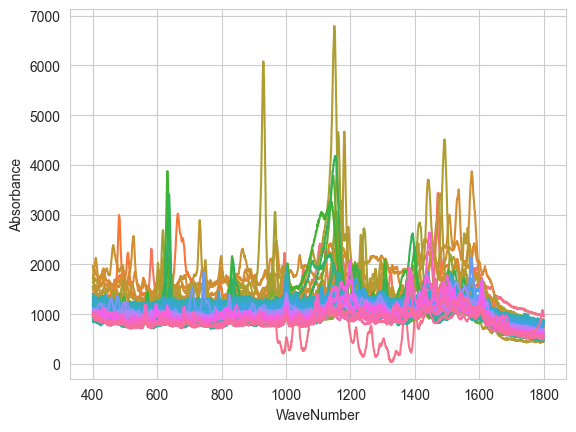

In [29]:
surface = raw_df[raw_df['SurID'] == SurID]
print(surface['SpecID'].nunique())
sns.lineplot(x="WaveNumber", y="Absorbance", data=surface, hue='SpecID', legend=None)

In [30]:
surface['PageRank'].describe()

count    102450.000000
mean          0.961240
std           0.776524
min           0.150004
25%           0.312081
50%           0.806071
75%           1.453088
max           2.872665
Name: PageRank, dtype: float64

22


<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

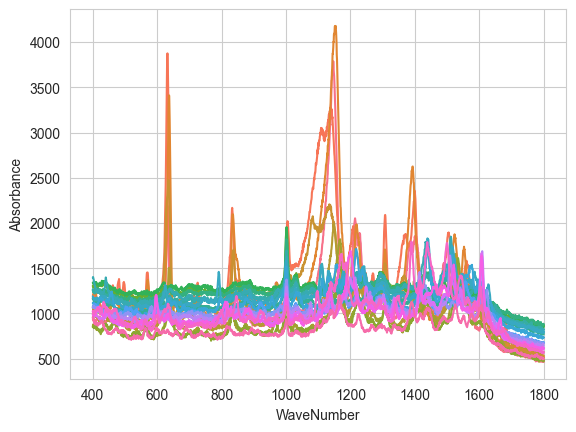

In [31]:
surface = surface[surface['PageRank'] > pagerank_cutoff]
print(surface['SpecID'].nunique())
sns.lineplot(x="WaveNumber", y="Absorbance", data=surface, hue='SpecID', legend=None)

50


<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

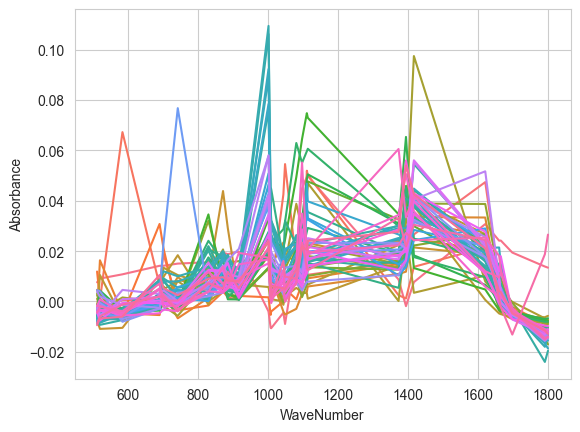

In [32]:
surface = df[df['SurID'] == SurID]
print(surface['SpecID'].nunique())
sns.lineplot(x="WaveNumber", y="Absorbance", data=surface, hue='SpecID', legend=None)

22


<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

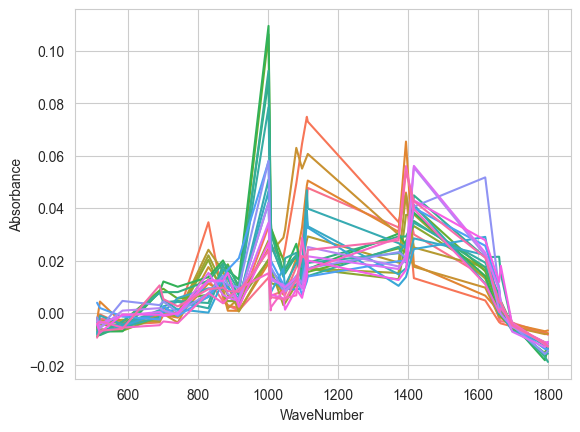

In [33]:
surface = surface[surface['PageRank'] > pagerank_cutoff]
print(surface['SpecID'].nunique())
sns.lineplot(x="WaveNumber", y="Absorbance", data=surface, hue='SpecID', legend=None)

The PageRank Filter Leaves the more representative spectra within a surface

#### **Machine Learning**

In [34]:
from sklearn.model_selection import cross_validate, GroupKFold
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report

In [35]:
def evaluate_random_forest(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    rf = RandomForestClassifier(random_state=1234, criterion='entropy', max_depth=23, n_estimators=78)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = cross_validate(rf, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

    # Displaying the results
    print(f"{rf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{rf.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{rf.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{rf.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [36]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')
evaluate_random_forest(wavelength_df)

c:\Users\FX 8320\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RandomForestClassifier Cross-Validation Accuracy: 0.6052 +/- 0.0787
RandomForestClassifier Cross-Validation Precision: 0.6030 +/- 0.0874
RandomForestClassifier Cross-Validation Recall: 0.6205 +/- 0.1257
RandomForestClassifier Cross-Validation F1-Score: 0.5812 +/- 0.1035


Try After PageRank Outlier Removal

In [37]:
df = df[df['PageRank'] > pagerank_cutoff]
wavelength_df = prepare_wavelength_df(df, 'Absorbance')
evaluate_random_forest(wavelength_df)

c:\Users\FX 8320\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RandomForestClassifier Cross-Validation Accuracy: 0.6961 +/- 0.0931
RandomForestClassifier Cross-Validation Precision: 0.6629 +/- 0.0797
RandomForestClassifier Cross-Validation Recall: 0.6609 +/- 0.0989
RandomForestClassifier Cross-Validation F1-Score: 0.6339 +/- 0.1008


In [38]:
def evaluate_random_forest_by_class(df):

    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']
    
    # Get unique class names from the 'y' dataset
    class_names = y.unique()

    rf = RandomForestClassifier(random_state=1234, criterion='entropy', max_depth=23, n_estimators=78)
    cv = GroupKFold(n_splits=10)

    accuracies = []
    precisions = [[] for _ in class_names]
    recalls = [[] for _ in class_names]
    f1_scores = [[] for _ in class_names]

    for train_idx, test_idx in cv.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        accuracies.append(accuracy_score(y_test, y_pred))
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, zero_division=0, labels=class_names)
        for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
            precisions[i].append(p)
            recalls[i].append(r)
            f1_scores[i].append(f)

    print(f"{rf.__class__.__name__} Cross-Validation Accuracy: {np.mean(accuracies):.4f} +/- {np.std(accuracies):.4f}\n")
    for i, class_name in enumerate(class_names):
        print(f"{class_name} Precision: {np.mean(precisions[i]):.4f} +/- {np.std(precisions[i]):.4f}")
        print(f"{class_name} Recall: {np.mean(recalls[i]):.4f} +/- {np.std(recalls[i]):.4f}")
        print(f"{class_name} F1-Score: {np.mean(f1_scores[i]):.4f} +/- {np.std(f1_scores[i]):.4f}\n")

In [39]:
evaluate_random_forest_by_class(wavelength_df)

RandomForestClassifier Cross-Validation Accuracy: 0.6961 +/- 0.0931

Normal Precision: 0.6599 +/- 0.2917
Normal Recall: 0.5490 +/- 0.3064
Normal F1-Score: 0.5649 +/- 0.2810

Hyperglycemia Precision: 0.5683 +/- 0.2201
Hyperglycemia Recall: 0.6640 +/- 0.2419
Hyperglycemia F1-Score: 0.6027 +/- 0.2117

Hypoglycemia Precision: 0.7606 +/- 0.2085
Hypoglycemia Recall: 0.7696 +/- 0.1667
Hypoglycemia F1-Score: 0.7341 +/- 0.1366



In [40]:
df.groupby('Status')['SpecID'].nunique()

Status
Hyperglycemia    502
Hypoglycemia     653
Normal           628
Name: SpecID, dtype: int64

#### **Finally Try to Predict the Surface by its predicted Spectra**

In [41]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank,Baseline
4263,201210-1-02,458,512.98407,0.004281,201210-1,Normal,0.961147,2044.242443
4275,201210-1-02,470,521.18451,-0.003189,201210-1,Normal,0.961147,2044.438693
4369,201210-1-02,564,585.42139,-0.002933,201210-1,Normal,0.961147,2045.983145
4524,201210-1-02,719,691.34393,0.014715,201210-1,Normal,0.961147,2048.562784
4540,201210-1-02,735,702.27789,0.009542,201210-1,Normal,0.961147,2048.832097
...,...,...,...,...,...,...,...,...
6239000,210526-3-09,2137,1660.36450,0.000648,210526-3,Hyperglycemia,1.201164,1813.086503
6239007,210526-3-09,2144,1665.14810,0.000575,210526-3,Hyperglycemia,1.201164,1811.012089
6239055,210526-3-09,2192,1697.94980,-0.004449,210526-3,Hyperglycemia,1.201164,1796.768563
6239191,210526-3-09,2328,1790.88840,-0.015137,210526-3,Hyperglycemia,1.201164,1756.317656


In [42]:
def evaluate_and_predict_surface_status(df):
   # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the RandomForestClassifier
    rf = RandomForestClassifier(random_state=1234, criterion='entropy', max_depth=23, n_estimators=78)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # DataFrame to store the actual and predicted status for each spectrum
    predictions_df = pd.DataFrame(columns=['SurID', 'ActualStatus', 'PredictedStatus'])

    # Iterating over each fold
    for train_index, test_index in cv.split(X, y, groups=groups):
        # Splitting the dataset into the current train and test set
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        groups_test = groups.iloc[test_index]
        
        # Fitting the model on the training set
        rf.fit(X_train, y_train)

        # Predicting the status for the test set
        y_pred = rf.predict(X_test)

        # Appending the SurID, actual, and predicted status to the predictions DataFrame
        fold_predictions = pd.DataFrame({
            'SurID': groups_test.values,
            'ActualStatus': y_test.values,
            'PredictedStatus': y_pred
        })
        predictions_df = pd.concat([predictions_df, fold_predictions], ignore_index=True)

    # Return the most common prediction of each spectra within the surface
    return predictions_df.groupby('SurID').agg(lambda x: x.mode()[0]).reset_index()

In [43]:
surface_predictions = evaluate_and_predict_surface_status(wavelength_df)
surface_predictions

,SurID,ActualStatus,PredictedStatus
0,201210-1,Normal,Normal
1,201210-2,Normal,Hypoglycemia
2,210114-1,Normal,Normal
3,210114-2,Normal,Normal
4,210120-1,Hyperglycemia,Hyperglycemia
...,...,...,...
58,210519-3,Hyperglycemia,Hyperglycemia
59,210524-1,Hypoglycemia,Hyperglycemia
60,210526-1,Hyperglycemia,Hyperglycemia
61,210526-2,Hyperglycemia,Normal


In [44]:
print(classification_report(surface_predictions['ActualStatus'], surface_predictions['PredictedStatus']))

               precision    recall  f1-score   support

Hyperglycemia       0.73      0.84      0.78        19
 Hypoglycemia       0.72      0.82      0.77        22
       Normal       0.75      0.55      0.63        22

     accuracy                           0.73        63
    macro avg       0.73      0.74      0.73        63
 weighted avg       0.73      0.73      0.72        63

